In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

In [2]:
# get CPI data for real value adjustment
# https://wire.insiderfinance.io/inflation-and-stock-market-61cbeeebaaf5

start = dt.datetime(1900, 1, 1)
end = dt.datetime(2023, 8, 31)
cpi_monthly = web.DataReader('CPIAUCSL', 'fred', start, end)

def get_cpi(timestamp):
    return next((y for (x, y) in cpi_monthly.CPIAUCSL.items()
                 if x.tz_localize("America/New_York") >= timestamp),
                max(*cpi_monthly.CPIAUCSL))

In [3]:
# raw histories

names = ["FSPSX", "FSKAX", "FBNDX", "FIPDX", "AMZN"]
tickers = {name: yf.Ticker(name) for name in names}
histories = {
    name: ticker.history(start="2022-09-30", end="2023-08-02", interval="1wk", actions="div,splits") 
    for (name, ticker) in tickers.items()
}

In [4]:
allocations = {
    "FSPSX": 0.67 * 0.25,
    "FSKAX": 0.67 * 0.75 * 0.8,
    "AMZN":  0.67 * 0.75 * 0.2,
    "FBNDX": 0.33 * 0.50,
    "FIPDX": 0.33 * 0.50,
#     "FBIIX": 0  # int'l bonds
}

In [5]:
# portfolio simulator

def simulate(allocations):
    last_values = {name: next(iter(history.Close)) for (name, history) in histories.items()}
    last_value = 1.
    blend = []
    timestamps = list(histories[names[0]].Close.keys())

    for (timestamp, *t) in zip(timestamps, *[tt.Close for tt in histories.values()]):
        this_value = 0
        for name, value in zip(histories, t):
            dividends = 0
            if "Dividends" in histories[name]:
                dividends += histories[name]["Dividends"][timestamp]
            if "Capital Gains" in histories[name]:
                dividends += histories[name]["Capital Gains"][timestamp]
            this_value += (value + dividends) / last_values[name] * allocations[name] * last_value
            last_values[name] = value

        blend.append((timestamp, this_value))
        last_value = this_value

    return blend

In [6]:
def one_hot(name):
    return {n: 1.0 if n == name else 0.0 for n in names}

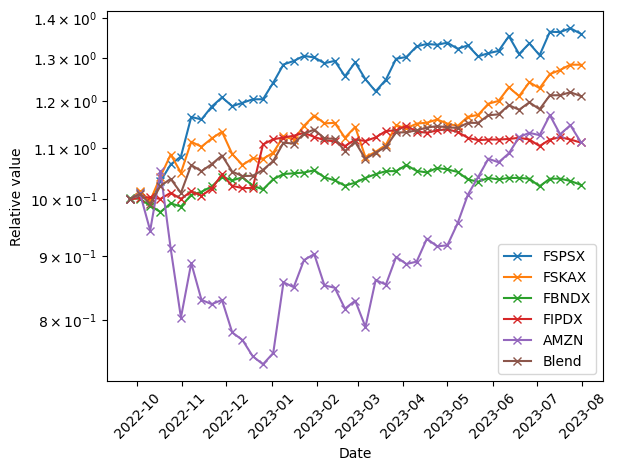

In [7]:
plt.figure()
plt.yscale("log")
plt.yticks(np.arange(0.5, 2.0, 0.1))

for name in names:
    value = simulate(one_hot(name))
    base_cpi = get_cpi(value[0][0])
    plt.plot([y[0] for y in value], [y[1] * base_cpi / get_cpi(y[0]) for y in value], marker="x")

value = simulate(allocations)
base_cpi = get_cpi(value[0][0])
plt.plot([y[0] for y in value], [y[1] * base_cpi / get_cpi(y[0]) for y in value], marker="x")    

plt.legend([*histories.keys(), "Blend"])

plt.xlabel("Date")
plt.ylabel("Relative value")
plt.xticks(rotation = 45)
plt.show()